In [1]:
# general imports
import math
import requests as rq

import numpy as np
import pandas as pd
import re
from urllib.request import urlopen
import json
import os
import pathlib

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.text import OffsetFrom
%matplotlib inline

In [2]:
# pandas formatting 
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# default plotting formats
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

cwd = pathlib.Path.cwd()
air_data_dir = cwd.joinpath("data","air_quality")
NOAH_WKDIR = cwd.joinpath("data","covid")
my_savedir = cwd.joinpath("local_covid")

# load county information for plotly from saved file 
with open('counties.json','r') as jin:
    counties = json.load(jin)



#Does not need to run, just documenting
def load_fips_mapping(file_path=None):
    f2c_map = pd.read_csv('temp.csv', usecols=['fips','county_name','state_name'], dtype={'fips':'string'})
    return f2c_map
    
def request_fips_mapping():
    r = rq.get('https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv')
    cleaned = r.text.replace('\r\n','\n')
    return cleaned
    # with open('temp.csv', 'w',encoding='utf-8') as tempout:
    #     tempout.write(cleaned)

## Utility functions

In [3]:
def FIPS_function(row):
    state = str(row['State Code']).zfill(2)
    county = str(row['County Code']).zfill(3)
    return str(state + county)
# convert to NO2 ug/m^3 for reference
def no2_mass_by_vol(ppb):
    ugm3 = 1.88*ppb
    return ugm3



def set_daily_cases_deaths(df):
    df['daily_new_cases'] = df['JHU_ConfirmedCases.data'].diff()
    df['daily_new_deaths'] = df['JHU_ConfirmedDeaths.data'].diff()
    return df
# plotting one day's avg 
def show_day_mean(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='Arithmetic Mean',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'Arithmetic Mean':'Arithmetic Mean (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig


# plotting one day's max value
def show_day_max(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='1st Max Value',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig   
def show_sites(df):
    fig = px.choropleth(df, geojson=counties, locations='fips', color='Parameter Code',
                               color_continuous_scale="Plasma",
                               range_color=(0, 1), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

def get_counties_df(file_name='./data/covid/config/counties.json'):
    with open(file_name) as file:
                county_data = json.load(file)
    
    df = pd.DataFrame.from_dict(county_data)
    
    data = [df[col] for col in df.columns]    
    
    # pivot
    return pd.DataFrame(data,columns=df.index, index=df.columns)

def get_fips_from_county_lookup():
    counties = get_counties_df() 
    counties = counties.dropna(subset=['fips'])
    counties.fips = counties.fips.apply(lambda f: eval(str(f)).get('id'))
    counties_index = {k: v for k, v in zip(counties.index, counties.fips)}
    def get_fips_from_county(county):
        return counties_index[county]
    return get_fips_from_county

def daily_avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day


In [4]:
# FIPS codes from the FCC.  Attempt to match all counties


def make_lookup_functions():
    fcc_county_file = NOAH_WKDIR.joinpath("config","fcc_county_fips.txt")
    with open(fcc_county_file) as fh:
        state = None
        fips_to_county = {}
        county_to_fips = {}
        for row in fh:
            if match := re.match(r'\s+(\d\d\d\d\d)\s+ (.*)', row):
                fips, location = match.groups()
                if fips.endswith('000'):
                    state = location.replace(' ','')
                    continue
                location = location.split(' County')[0]
                location = location.split(' Borough')[0]
                location = location.split(' Census Area')[0]
                location = location.split(' Parish')[0]
                location = location.split(' National Park')[0]
                
                if state == 'Florida' and location == 'Dade':
                    location = 'Miami-Dade'
                if state == 'Massachusetts' and location == 'Dukes':
                    location = 'DukesandNantucket'
                if state == 'Alaska' and location == 'Wrangell-Petersburg':
                    location = 'Wrangell'
                if state == 'Alaska' and location == 'Skagway-Hoonah-Angoon':
                    location = 'Skagway'
                if state == 'Alaska' and location == 'Prince of Wales-Outer Ketchikan':
                    location = 'Prince of Wales'
                if state == 'New York' and location == 'New York':
                    location = 'New York City'
                    
                try:
                    location = ''.join([s[0].upper() + s[1:] for s in location.split(' ')])    
                except Exception as e:
                    pass  # garbage

                county = location.replace(' ', '') + '_' + state + '_UnitedStates'
                fips_to_county[int(fips)] = county
                county_to_fips[county.lower()] = int(fips)
                
        def lookup_county_from_fips(fips_):
            return fips_to_county[int(fips_)]
        
        def lookup_fips_from_county(county_):
            try:
                return county_to_fips[county_.lower()]
            except KeyError:
                pass
            
            try:
                county_ = county_.lower()
                parts = county_.split('_')
                parts[0] = parts[0][:parts[0].index('city')]
                return county_to_fips['_'.join(parts)]
            except:
                pass
            
            try:
                parts = county_.split('_')
                parts[0] = parts[0] +'city'
                return county_to_fips['_'.join(parts)]
            except:
                pass
    
            parts = county_.split('_')
            for k, v in county_to_fips.items():
                part0, part1, _ = k.split('_')
                if part1 != parts[1]:
                    continue
                if parts[0].startswith(part0) or part0.startswith(parts[0]):
                    return v

            raise KeyError
                
        
        return lookup_county_from_fips, lookup_fips_from_county

get_county_from_fips,  get_fips_from_county = make_lookup_functions()

# Loading EPA Data

#### Argument for removing columns
 
We are looking for a link between 2 datasets, for now we will assume things like the 'POC' field (This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.) are unimportant to our investigation.

Similarly we will remove the method code, method name, ect.

more information on the field definitions can be found here -> https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_content_4

## Loading and merging no2 for 2020 and 2021

In [5]:
# parser warned to use the pd.to_datetime instead
no2_20 = pd.read_csv(air_data_dir.joinpath("no2","daily_no2_2020_with_FIPS.csv"), dtype={'fips':'string'})
# putting datetime in new column out of an abundace of caution
no2_20['Date Local'] = pd.to_datetime(no2_20['Date Local'], format="%Y/%m/%d")

no2_columns = ['Date Local','fips',
               'Arithmetic Mean','AQI',
               '1st Max Value','Units of Measure',
               'Mean ugm3','Site Num',
               'Event Type','Latitude',
               'Longitude','State Code','County Code',
               'Observation Count','Observation Percent']
slim_no2_20 = no2_20[no2_columns]


In [6]:
no2_21 =  pd.read_csv(air_data_dir.joinpath("no2","daily_no2_2021_with_FIPS.csv"), dtype={'fips':'string'})
no2_21['Date Local'] = pd.to_datetime(no2_21['Date Local'], format="%Y/%m/%d")
no2_columns = ['Date Local','fips',
               'Arithmetic Mean','AQI',
               '1st Max Value','Units of Measure',
               'Mean ugm3','Site Num',
               'Event Type','Latitude',
               'Longitude','State Code','County Code',
               'Observation Count','Observation Percent']
slim_no2_21 = no2_21[no2_columns]

In [7]:
slim_no2 = pd.concat([slim_no2_20,slim_no2_21])


## Issue: multiple sample sites in some counties

Some counties have multiple air monitoring stations. Below code builds a dictionary whose keys are the fips codes with multiple sites.

In [8]:
# multiple sites in one county
slim_no2.loc[(slim_no2['Date Local']=='2020-01-01') & (slim_no2['fips']=='06001')].head()

,Date Local,fips,Arithmetic Mean,AQI,1st Max Value,Units of Measure,Mean ugm3,Site Num,Event Type,Latitude,Longitude,State Code,County Code,Observation Count,Observation Percent
4002,2020-01-01,06001,7.865217,17,18.5,Parts per billion,14.786608,7,None,37.687526,-121.784217,6,1,23,96.0
4368,2020-01-01,06001,12.617391,20,21.3,Parts per billion,23.720695,9,None,37.743065,-122.169935,6,1,23,96.0
4733,2020-01-01,06001,15.921739,26,28.0,Parts per billion,29.932869,11,None,37.814781,-122.282347,6,1,23,96.0
5096,2020-01-01,06001,15.934783,22,23.2,Parts per billion,29.957392,12,None,37.793624,-122.263376,6,1,23,96.0
5462,2020-01-01,06001,12.826087,22,23.5,Parts per billion,24.113044,13,None,37.864767,-122.302741,6,1,23,96.0


### A Quick naive solution

... we can average the averages for each county.

This method below achieves this but the other columns are not captured.

In [9]:
daily_avg_no2 = daily_avg_county_pollution(slim_no2)
daily_avg_no2.head()

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 01073        16.373918           31.0   29
           04013        16.660833           34.0   32
           04019        11.206250           23.7   22
           05035         9.175000           23.1   22
           05119        12.637500           28.9   26

In [10]:
# reset index, then take the year's average per fips (dropping the max value since we want avgs anyway). This will be our benchmark
county_means =daily_avg_no2.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)

### Creating dictonary of the avg ppb and AQI per county for 2020

In [11]:
county_means.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_benchmarks = county_means.to_dict('index')
county_benchmarks['04013']['mean_ppb']

15.597742065935673

## Building functions to identify important dates

In [12]:
def check_level(df, averages, delta=0):
    """Return dictonary with higher than average ppb for each fips code.
    
    
    Parameters:
    
    df -- single full dataframe
    
    averages -- dict of structure fips:(mean_ppb, AQI)
    
    delta -- ppb difference to flag, default = 0
    
    The averages dictionary should have one entry per fips code, giving the average concentration for that county.
    
    Return:
    peaks -- dict of structure fips:[{'Date_Local' dates]
    """
    
    targets = {}
    for fipc in list(averages.keys()):
        df[df['fips']==fipc]
        peak_df = df[(df['fips']==fipc) & (df['Arithmetic Mean'] >= (averages[fipc]['mean_ppb'] + delta))]
        targets[fipc] = peak_df[['Date Local','Arithmetic Mean']].to_dict('index')
    return targets

In [13]:
flat_daily_avg = daily_avg_no2.reset_index()
to_cross_ref = check_level(flat_daily_avg, county_benchmarks, delta=15)

In [14]:
to_cross_ref['01073']

{1744: {'Date Local': Timestamp('2020-01-08 00:00:00'),
  'Arithmetic Mean': 30.13},
 85413: {'Date Local': Timestamp('2020-12-10 00:00:00'),
  'Arithmetic Mean': 25.422916999999998}}

The peak times from the above show an increase during the fall/winter months, I would be fine comparing trends into and out of this time period

# Cross check data

With the dict of list of dicts above we can take the key (fips) and the dates within to select the correct data from the covid19 repository and establish a window of effect

- Select fips & date from peak dates
    - Might want to select window of days surrounding the peak
- grab covid data for peak dates
    - will want days leading up to and trailing the peak dates


 

In [15]:
# helper function for me to load one of the pickles provided by Noah
def load_covid_by_fips(fipcode):
    df = pd.read_pickle(NOAH_WKDIR.joinpath("processed_data","county_merged_parts",get_county_from_fips(fipcode)+'.pkl'))   
    return df
clamped_covid = ['fips','JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                 'latestTotalPopulation','MaleAndFemale_AtLeast65_Population.data',
                 'Male_Total_Population.data','Female_Total_Population.data',
                 'MaleAndFemale_Under18_Population.data','BLS_EmployedPopulation.data',
                 'BLS_UnemployedPopulation.data','BLS_UnemploymentRate.data',
                 'BLS_LaborForcePopulation.data','AverageWindDirection.data',
                ]

def stringify_fips(row):
    ''' Convert the INTeger representation of fips to a string with leading zeros.
            intended to be used in a lamda function.
            
    Arguments:
    
    row - a single row of a dataframe. Intended to be used like "df4.apply(lambda row: stringify_fips(row), axis=1)"
    
    '''
    strFips = str(row['fips']).zfill(5)
    return strFips

def rolling_cases(df, window_size=7):
    df['1wkroll'] = df['daily_new_cases'].rolling(window=window_size).mean()
    df.reset_index(inplace=True)
    df.set_index("dates",inplace = True)
    return df

# cases / 100,000 people
def set_weighted_cases(df):
    wpop =  df['latestTotalPopulation'].max()/100000
    z = df.loc[:,'JHU_ConfirmedCases.data'] / wpop
    df['total_cases_per_100k'] = z.values    
    return df

#deaths per person infected
def set_death_per_cases(df):
    df.loc[:,'deaths_per_cases']= np.where((df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data'])>=0,
                                          (df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data']), 0)
    return df
    

In [16]:
# To make the covid data play nice with my current setup I need to do some processing 

def load_and_augment_fips(fips):
    tdf = load_covid_by_fips(fips)
    # pickle loads numbers as floats; converting fips to int
    tdf['fips'] = tdf.apply(lambda row: math.floor(row['fips']), axis=1)

    # Making fips a string to match on other datasets with leading zero
    df2= tdf.astype({"fips":"int"}).astype({'fips':'string'})
    
    # adding leading zero where needed
    df2['fips'] = df2.apply(lambda row: stringify_fips(row), axis=1)
    
    #need daily change in cases to get the rolling delta of new infections
    df2 = set_daily_cases_deaths(df2)
    df2 = rolling_cases(df2)
    df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
    top_level_covid = ['fips','daily_new_cases','daily_new_deaths', "1wkroll",
                   'JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                   'latestTotalPopulation']
    
    
    df3 = df2[top_level_covid].copy()
    df3 = set_weighted_cases(df3)
    df3 = set_death_per_cases(df3)
    # clunky? yes. Technically safest way to do this in pandas (i think) feel free to edit
    del df2
    del tdf
    
    
    
    return df3

## Leveraging the datetime functionality in pandas

In [17]:
no2df = daily_avg_no2.reset_index().set_index("Date Local")
tdate = pd.Timestamp('2020-12-10')
# days forward and backward to look
offset = pd.offsets.Week()

### Verify values

According to the [nytimes covid information](https://www.nytimes.com/interactive/2021/us/covid-cases.html), Jefferson Alabama (Fips = '01073') has a total case number = 1 in 6 of the population and deaths 1 in 330. 

Lets see what our data says

In [18]:
covdf2 = load_and_augment_fips("01073")

In [19]:
tcase_for_pop = covdf2["JHU_ConfirmedCases.data"].max()/covdf2["latestTotalPopulation"].max()
tcase_for_pop

0.15336492689496836

In [20]:
print(f"given the estimate of {1/6} from the nyt, we found a case rate of {tcase_for_pop} for the population of Jefferson county")

given the estimate of 0.16666666666666666 from the nyt, we found a case rate of 0.15336492689496836 for the population of Jefferson county


### Simplistic rolling averages

It is agreed that No2 has an effect on the immune system but estimates of the duration of that impact vary.

In [45]:
# getting a rolling average of the no2 concentrations
no2_rolling_mean = no2df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
no2_rolling_weakly = no2df.groupby("fips")[['Arithmetic Mean']].rolling(window=7).mean()
no2_rolling_peak = no2_rolling_mean.groupby("fips").idxmax()

no2_raw_peak = no2df.groupby("fips")[['Arithmetic Mean']].idxmax()

rolling_peaks_dict = {}

for artup in no2_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict[tup[0]] = tup[1]

raw_peaks_dict = {}
for tup in no2_raw_peak.itertuples():
    raw_peaks_dict[tup[0]] = tup[1]

In [53]:
no2_rolling_weakly.head()

Arithmetic Mean
fips  Date Local                 
01073 2020-01-01              NaN
      2020-01-02              NaN
      2020-01-03              NaN
      2020-01-04              NaN
      2020-01-05              NaN

In [54]:
no2_week_rolldf = no2_rolling_weakly.reset_index().set_index("Date Local")

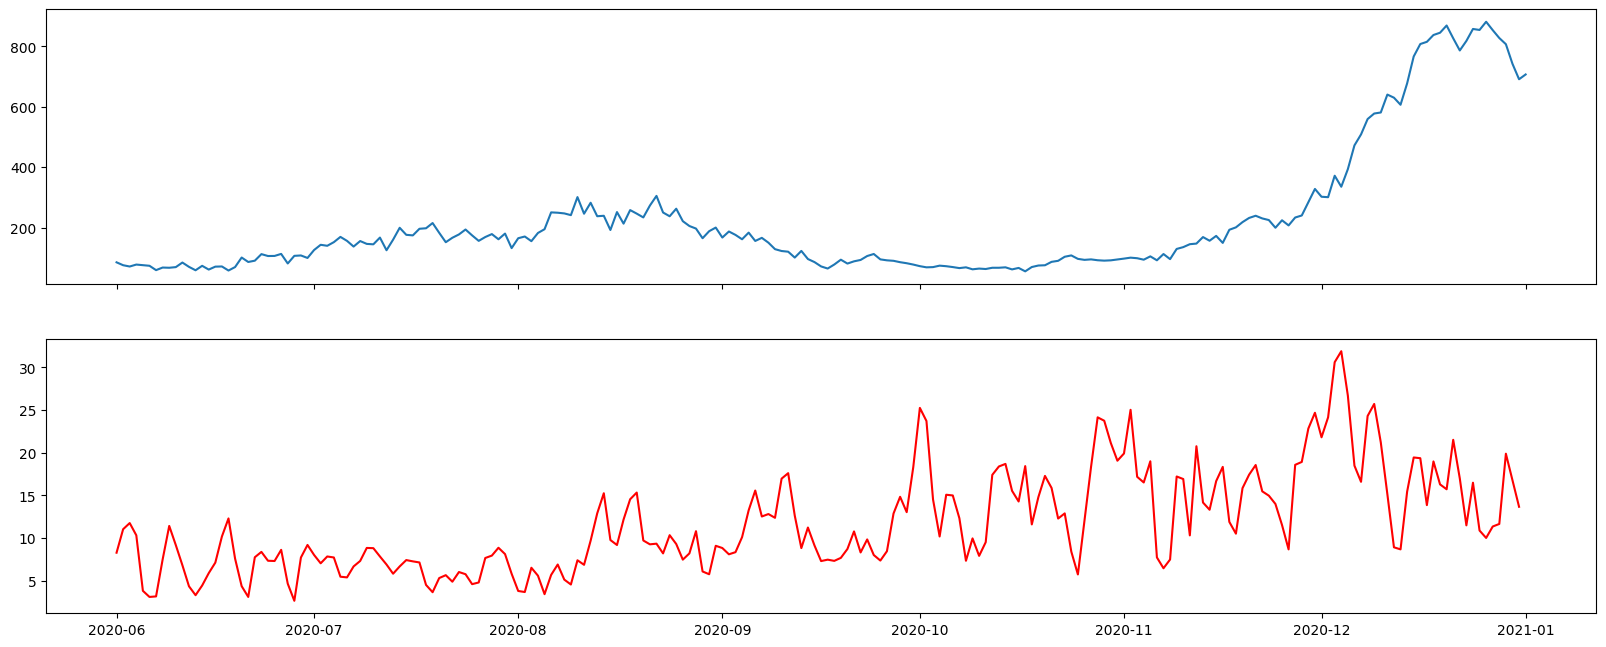

In [67]:
fig, axs = plt.subplots(2,1,figsize =(20,8), sharex=True)
tfip = "06001"
cov_df = load_and_augment_fips(tfip)

# axs.set_title("NO2 raw data for Navarro Texas")
axs[1].plot(no2df[no2df['fips']==tfip].loc['2020-6-01':]['Arithmetic Mean'],'r')
axs[0].plot(cov_df.loc['2020-6-01':'2021-01-01']['1wkroll'])
# axs[1].plot(no2_week_rolldf[no2_week_rolldf['fips']==tfip].loc['2020-6-01':]['Arithmetic Mean'],'r')

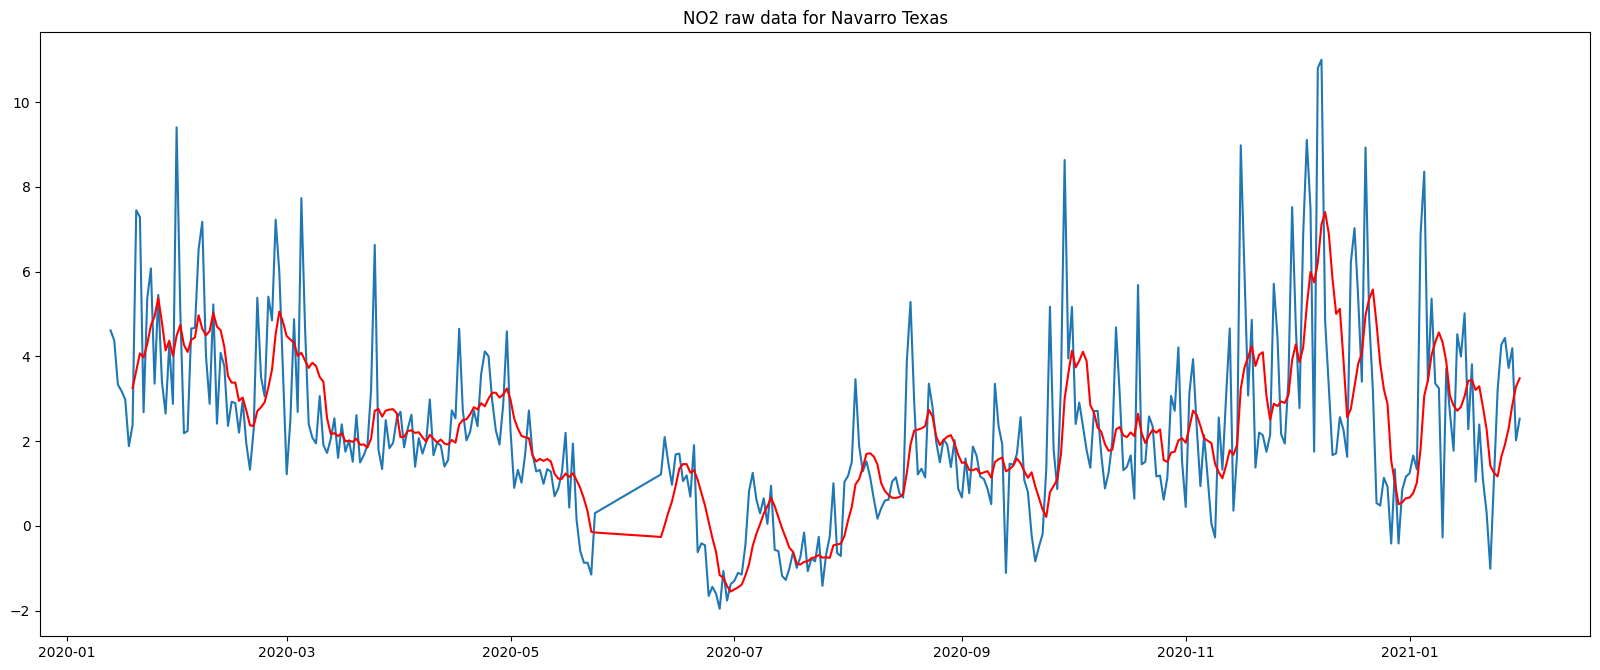

In [52]:
fig, axs = plt.subplots(1,1,figsize =(20,8), sharex=True)
tfip = "48349"
axs.set_title("NO2 raw data for Navarro Texas")
axs.plot(no2df[no2df['fips']==tfip]['Arithmetic Mean'])
# axs[1].set_title("rolling mean")
axs.plot(qpdf[qpdf['fips']==tfip]['Arithmetic Mean'],'r')

### Our (estimated) threshold compared to the data

We selected a threshold of 15 ppb above each county's yearly average concentration. It should be noted that in animal trials, some effects has been observed from exposure to as little as 5ppb, however the immunosupressive aspect is less prominant in these concentrations. The antibody titers had not changed in the animals but there was a decline in the production of antibody-forming cells but no other immune metric saw a change https://pubmed.ncbi.nlm.nih.gov/3959113/

In [22]:
# confirming that +15 ppb is actually above the std div
stdList = flat_daily_avg.groupby("fips")['Arithmetic Mean'].std()
stdList[:10]

fips
01073    4.678560
04013    6.425989
04019    3.936105
05035    3.790456
05119    3.877636
06001    5.764433
06007    3.266836
06013    3.525177
06019    5.229202
06023    1.469440
Name: Arithmetic Mean, dtype: float64

In [23]:
def dual_plot(tfip, no2df,rolling_peaks_dict):
    elist = []
    center_date = rolling_peaks_dict[tfip]
    covdf2 = load_and_augment_fips(tfip)       
    
    fig, axs = plt.subplots(2,1,figsize =(11,8), sharex=True)
    no2_vals = no2df[no2df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
    cov_interval = covdf2.loc[center_date - offset:center_date+offset]    
    title_text = "{} daily cases".format(tfip)
    axs[0].set_title(title_text)
    axs[0].plot(cov_interval["daily_new_cases"],'b',label="daily cases")
    # axs[0].plot(cov_interval["daily_new_cases"].shift(-7,freq="D"),'r', label="shifted back 7 days")
    axs[0].legend()
    axs[1].plot(no2_vals)
    axs[1].set_title("NO2 concentrations")
    # fig.update_layout(
    #         autosize=False,
    #         width=1300,
    #         height=1100,)
    # fig.savefig(cwd.joinpath("no2_images","county_peak_plots",f"{tfip}_comparison.jpg"))
    # plt.close()


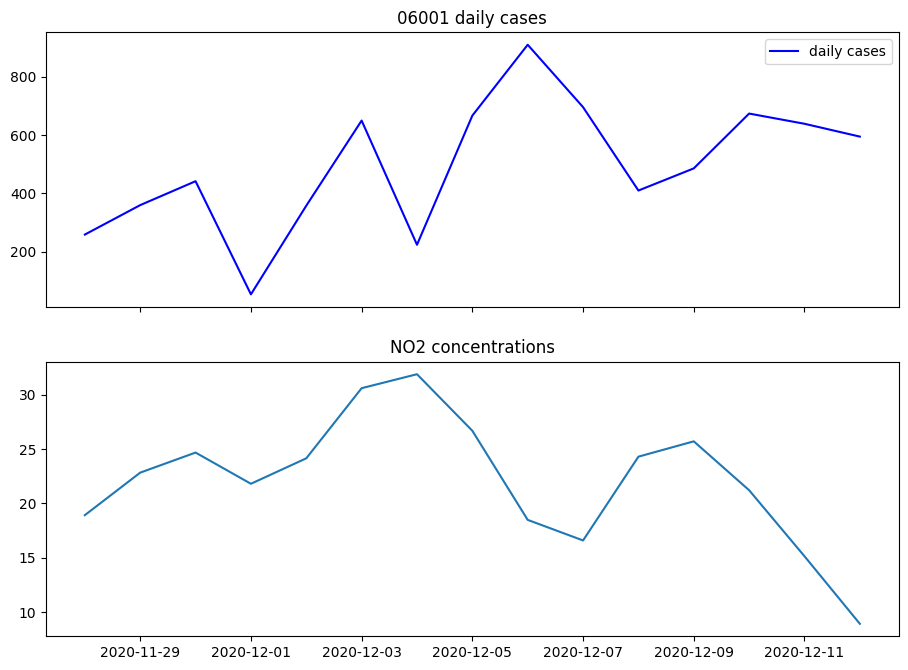

In [24]:
dual_plot('06001', no2df, rolling_peaks_dict)

In [25]:
reflist= list(to_cross_ref.values())
reflist[0]

{1744: {'Date Local': Timestamp('2020-01-08 00:00:00'),
  'Arithmetic Mean': 30.13},
 85413: {'Date Local': Timestamp('2020-12-10 00:00:00'),
  'Arithmetic Mean': 25.422916999999998}}

In [26]:
cref_keys = list(to_cross_ref.keys())

# Correlations

## Raw Correlations

In [27]:
# no2df

cdf = load_and_augment_fips(cref_keys[4])
# target pollution dataframe = tpdf
tpdf=no2df[no2df['fips'] == cref_keys[4]].copy() # ensure we can manipulate as needed
cor_df = tpdf.join(cdf,lsuffix="_L", rsuffix="_R")

In [28]:
cor_df.head()

,fips_L,Arithmetic Mean,1st Max Value,AQI,fips_R,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Date Local,,,,,,,,,,,,,
2020-01-01,05119,12.637500,28.9,26,05119,NaN,NaN,NaN,0.0,0.0,391911.0,0.0,0.0
2020-01-02,05119,11.736364,23.5,22,05119,0.0,0.0,NaN,0.0,0.0,391911.0,0.0,0.0
2020-01-03,05119,5.033333,9.5,8,05119,0.0,0.0,NaN,0.0,0.0,391911.0,0.0,0.0
2020-01-04,05119,6.541667,31.1,29,05119,0.0,0.0,NaN,0.0,0.0,391911.0,0.0,0.0
2020-01-05,05119,12.566667,26.3,25,05119,0.0,0.0,NaN,0.0,0.0,391911.0,0.0,0.0


In [29]:
cor_df.drop(['fips_L','fips_R','latestTotalPopulation'],axis=1,inplace=True)

In [30]:
cor_df.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.824795,0.822294,0.192969,0.136487,0.224025,0.239878,0.235991,0.239878,-0.252937
1st Max Value,0.824795,1.000000,0.998902,0.110580,0.046509,0.157150,0.228758,0.222301,0.228758,-0.211751
AQI,0.822294,0.998902,1.000000,0.113076,0.047419,0.157322,0.228856,0.222372,0.228856,-0.214951
daily_new_cases,0.192969,0.110580,0.113076,1.000000,0.445556,0.636134,0.342490,0.338872,0.342490,0.022335
daily_new_deaths,0.136487,0.046509,0.047419,0.445556,1.000000,0.427733,0.346763,0.352212,0.346763,0.064365
1wkroll,0.224025,0.157150,0.157322,0.636134,0.427733,1.000000,0.580560,0.573934,0.580560,0.010104
JHU_ConfirmedCases.data,0.239878,0.228758,0.228856,0.342490,0.346763,0.580560,1.000000,0.998458,1.000000,-0.029490
JHU_ConfirmedDeaths.data,0.235991,0.222301,0.222372,0.338872,0.352212,0.573934,0.998458,1.000000,0.998458,-0.001165
total_cases_per_100k,0.239878,0.228758,0.228856,0.342490,0.346763,0.580560,1.000000,0.998458,1.000000,-0.029490
deaths_per_cases,-0.252937,-0.211751,-0.214951,0.022335,0.064365,0.010104,-0.029490,-0.001165,-0.029490,1.000000


### Low correlation values

It's my suspision that the relatively low correlation values we see here are due in part to the fact the no2 levels vary during the period prior to the area in question seeing a covid case.

Text(0.5, 1.0, 'NO2 concentrations')

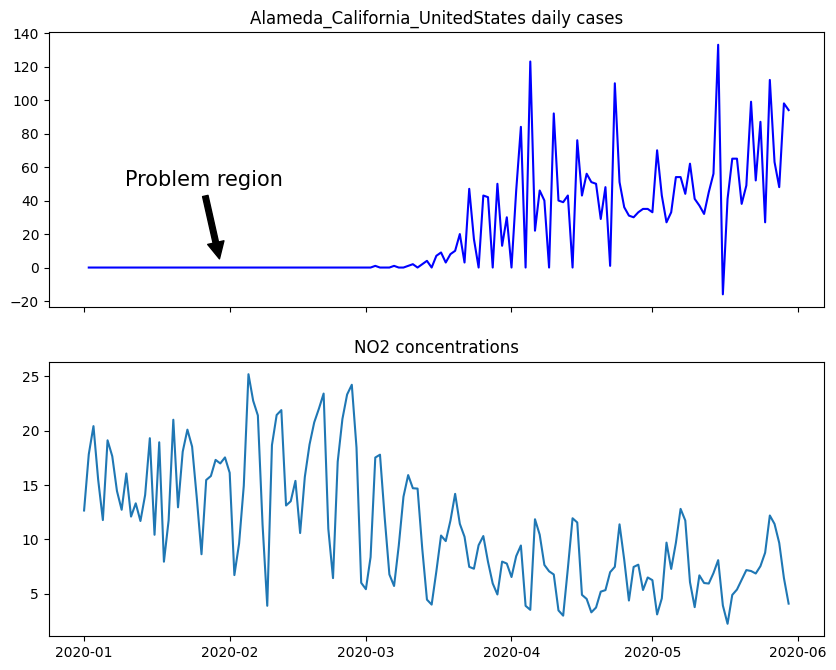

In [31]:
import matplotlib.collections as collections
tfip = "06001"
covdf = load_and_augment_fips(tfip)
covdf2 = covdf.loc[:'2020-05-30']
fig, axs = plt.subplots(2,1,figsize =(10,8), sharex=True)
no2_vals =no2df[no2df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

axs[0].set_title(covid_title_text)
axs[0].plot(covdf2["daily_new_cases"],'b',label="daily cases")
axs[0].annotate('Problem region',
            xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
            xytext=(0.2, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',shrink=0.05),
             horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(no2_vals)
axs[1].set_title("NO2 concentrations")


So we will cut out the dates leading up to march from both datasets. That way we are not attempting to correlate prior to the effect being present.

In [32]:
tempdf = load_and_augment_fips(cref_keys[4])
tightdf = tempdf.loc['2020-05-20':'2021-03-01']
narrow_covid = tightdf.drop(["fips","latestTotalPopulation"], axis =1)
tno2 = no2df[no2df['fips'] == cref_keys[4]].copy()
tno2 = tno2.loc['2020-05-20':'2021-03-01']

tight_correlation = tno2.join(tightdf,lsuffix="_L", rsuffix="_R")

In [33]:
tight_correlation.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.833260,0.830373,0.236470,0.159825,0.291976,0.326344,0.335850,NaN,0.326344,-0.243483
1st Max Value,0.833260,1.000000,0.998885,0.150550,0.054296,0.215411,0.271045,0.273467,NaN,0.271045,-0.220100
AQI,0.830373,0.998885,1.000000,0.154376,0.056238,0.215736,0.271765,0.274224,NaN,0.271765,-0.220085
daily_new_cases,0.236470,0.150550,0.154376,1.000000,0.400499,0.554820,0.343062,0.337933,NaN,0.343062,-0.257245
daily_new_deaths,0.159825,0.054296,0.056238,0.400499,1.000000,0.367004,0.262473,0.267916,NaN,0.262473,-0.166982
1wkroll,0.291976,0.215411,0.215736,0.554820,0.367004,1.000000,0.681029,0.672009,NaN,0.681029,-0.499140
JHU_ConfirmedCases.data,0.326344,0.271045,0.271765,0.343062,0.262473,0.681029,1.000000,0.998061,NaN,1.000000,-0.545556
JHU_ConfirmedDeaths.data,0.335850,0.273467,0.274224,0.337933,0.267916,0.672009,0.998061,1.000000,NaN,0.998061,-0.522867
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,0.326344,0.271045,0.271765,0.343062,0.262473,0.681029,1.000000,0.998061,NaN,1.000000,-0.545556


In [34]:
tight_correlation.corr(method='spearman')

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.858712,0.858289,0.154337,0.181229,0.311168,0.375408,0.375533,NaN,0.375408,-0.165918
1st Max Value,0.858712,1.000000,0.999065,0.147712,0.135899,0.249501,0.269779,0.269567,NaN,0.269779,-0.178829
AQI,0.858289,0.999065,1.000000,0.145735,0.132261,0.248471,0.269003,0.268790,NaN,0.269003,-0.175842
daily_new_cases,0.154337,0.147712,0.145735,1.000000,0.272409,0.460083,0.254579,0.253091,NaN,0.254579,-0.257137
daily_new_deaths,0.181229,0.135899,0.132261,0.272409,1.000000,0.299572,0.301212,0.305804,NaN,0.301212,-0.146839
1wkroll,0.311168,0.249501,0.248471,0.460083,0.299572,1.000000,0.718423,0.717759,NaN,0.718423,-0.446033
JHU_ConfirmedCases.data,0.375408,0.269779,0.269003,0.254579,0.301212,0.718423,1.000000,0.999921,NaN,1.000000,-0.588603
JHU_ConfirmedDeaths.data,0.375533,0.269567,0.268790,0.253091,0.305804,0.717759,0.999921,1.000000,NaN,0.999921,-0.587427
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,0.375408,0.269779,0.269003,0.254579,0.301212,0.718423,1.000000,0.999921,NaN,1.000000,-0.588603


In [35]:
tempdf[tempdf['JHU_ConfirmedCases.data'] >1000].head()

,fips,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
dates,,,,,,,,,
2020-06-03,05119,34.0,0.0,27.857143,1003.0,35.0,391911.0,255.925452,0.034895
2020-06-04,05119,36.0,2.0,29.857143,1039.0,37.0,391911.0,265.111211,0.035611
2020-06-05,05119,26.0,0.0,31.285714,1065.0,37.0,391911.0,271.745371,0.034742
2020-06-06,05119,26.0,0.0,30.714286,1091.0,37.0,391911.0,278.379530,0.033914
2020-06-07,05119,12.0,0.0,30.714286,1103.0,37.0,391911.0,281.441450,0.033545


Text(0.5, 1.0, 'NO2 concentrations')

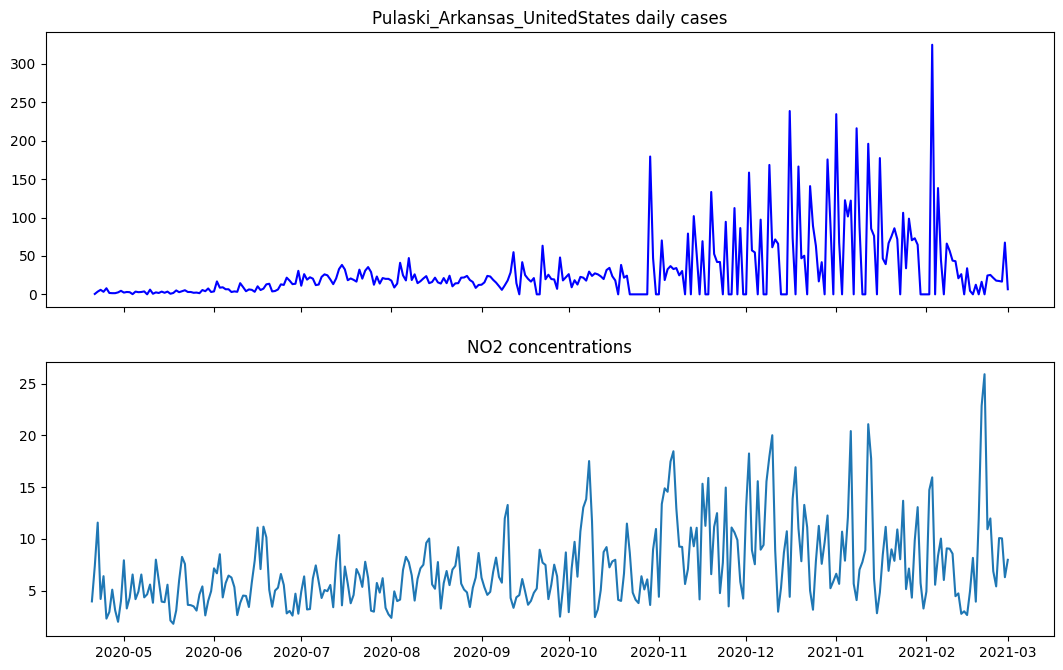

In [52]:
tfip='05119'
covdf2 = tempdf.loc['2020-04-20':'2021-03-01']
fig, axs = plt.subplots(2,1,figsize =(13,8), sharex=True)
no2_vals =no2df[no2df['fips'] == tfip]["Arithmetic Mean"].loc['2020-04-20':'2021-03-01']
covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

axs[0].set_title(covid_title_text)
axs[0].plot(covdf2["total_cases_per_100k"].diff(),'b',label="daily cases")
# axs[0].annotate('Problem region',
#             xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
#             xytext=(0.2, 0.5), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',shrink=0.05),
#              horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(no2_vals)
axs[1].set_title("NO2 concentrations")

# Idea for correlation 

instead of plotting all the peaks ect automate the removal of the pre pandemic data, then do the correlations for each county and pop them into a df/csv by county.

In [40]:
get_county_from_fips('56013')

'Fremont_Wyoming_UnitedStates'